In [54]:
from scipy.signal import argrelextrema
from scipy.interpolate import lagrange
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import plotly.graph_objs as go
from scipy.interpolate import CubicSpline
from numpy.random import rand
from collections import OrderedDict

def Auto_regr2(x0, x1, N, p, a, b, t0):
    size = (int(p) + N)
    X = [0]*size
    X[0] = x0
    X[1] = x1
    t = [0]*(size)
    t[0] = 0
    t[1] = 1
    t[2] = 2
    max_val, min_val = 1, -1
    range_size = (max_val - min_val)
    
    for n in range(2,N):
        for i in range(1,p+1):
            t[i+n] = i+n
            ksi = int((rand(1) * range_size + min_val)%10)
            if t[i+n] < t0:
                X[n+i] = sum(a[i] * X[n-p+i] + ksi for i in range(p)) #p=2, отсчет от 0, учли n - (p+1)
            else:
                X[n+i] = sum(b[i] * X[n-p+i] + ksi for i in range(p))
    return (t[:-1],X[:-1])

def ploter(x_values, y_values):
    plt.plot(x_values, y_values, marker='o', linestyle='-')  # Линия и точки
    plt.title('График с точками и линиями')
    plt.xlabel('t')
    plt.ylabel('X')
    plt.grid(True)
    plt.show()

def plotly_plot(x_vals, y_vals):
    ex = go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='markers',
        marker=dict(
        size=12,
        color='blue',  # Цвет точек
        symbol='circle',  # Форма точек
        line=dict(
            width=2,
            color='DarkSlateGrey'  # Цвет границы точек
        )
        )
    )
    ex_lines = go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='lines+markers',  # Линии и точки
        line=dict(
            color='blue',  # Цвет линии
            width=2  # Ширина линии
        ),
        marker=dict(
            size=8,
            color='red',  # Цвет точек
            symbol='circle',  # Форма точек
            line=dict(
                width=2,
                color='DarkSlateGrey'  # Цвет границы точек
            )
            )
    )
    layout = go.Layout(
        title = 'График',
        xaxis=dict(title='t'), 
        yaxis=dict(title='X(t)'),
    )
    fig = go.Figure(data = [ex, ex_lines], layout=layout)
    fig.show()


def Huang_algo(X,t, eps):
    # ITER1
    def ITER1(Xk, tk):
        i = 1
        set_max = []; set_min = []
        t_max = []; t_min = []
        for ti in tk:
            if i > 0 and i < len(tk):
                set_max.append(max(Xk[i-1:i+1])); t_max.append(Xk.index(max(Xk[i-1:i+1])))
                set_min.append(min(Xk[i-1:i+1])); t_min.append(Xk.index(min(Xk[i-1:i+1])))
                
                i+=4
            else:
                i+=1
        X_max = {t_max[i]: set_max[i] for i in range(len(t_max))}; X_min = dict(zip(t_min, set_min))
        if len(X_max) != len(X_min):
            pass
        X_max = {key: X_max[key] for key in sorted(X_max.keys())}
        X_min = {key: X_min[key] for key in sorted(X_min.keys())}
        return X_max, X_min

    X_max, X_min = ITER1(X, t)
    h = []
    #ITER2
    def criterion(hi, hj):
        return np.sum((hi - hj)**2) / (np.sum(hj**2))

    def u_min(minimum, t):
        return minima(t)

    def u_max(maxima, t):
        return maxima(t)
    #print(X_max.keys())
    #print([X_max[key] for key in X_max.keys()])
    #print(X_min.keys())
    #print([X_min[key] for key in X_min.keys()])
    #print(X_max.keys())
    maxima = CubicSpline(np.array(list(X_max.keys())), np.array(list(X_max.values())))
    minima = CubicSpline(np.array(list(X_min.keys())), np.array(list(X_min.values())))
    m1 = (np.array(list(map(lambda tau: u_max(maxima,tau), t))) + np.array(list(map(lambda tau: u_min(minima,tau), t)))) / 2 ; h2 = np.array(X - m1) ; h1 = np.array(X)
    i = 0
    h.append(h2)
    #print(m1)
    while criterion(h2,h1) > eps:
        h1 = np.copy(h2)
        X_max, X_min = ITER1(list(h1), t)
        maxima = CubicSpline(np.array(list(X_max.keys())), np.array(list(X_max.values())))
        minima = CubicSpline(np.array(list(X_min.keys())), np.array(list(X_min.values())))
        m2 = (np.array(list(map(lambda tau: u_max(maxima,tau), t))) + np.array(list(map(lambda tau: u_min(minima,tau), t)))) / 2 ;
        h2 = h1 - m2
        if i <1:
            print("Start delta: ", criterion(h2,h1))
            #print(h[-1])
            #print(m2)
        i +=1
        h.append(h2)

    print("iterations: ", i)
    print("result delta: ", criterion(h2,h1))
    return t, h2, h

In [60]:
def Visual_res(a_coef, b_coef, eps, x0, x1, n, p, t):
    x, y= Auto_regr(x0,n, p, a_coef, b_coef, t)
    ploter(x,y)
    t, h = Huang_algo(y, x, eps)
    ploter(t, h)
    return x, y
    
def Visual_res2(a_coef, b_coef, eps, x0, x1, n, p, t):
    #print("a: ", a_coef)
    #print("b: ", b_coef)
    x, y= Auto_regr2(x0, x1, n, p, a_coef, b_coef, t)
    #print(x,y)
    plotly_plot(x,y)
    t, h_n, h = Huang_algo(y, x, eps)
    h_res = np.sum(h, axis=0)
    #h_res += h_n
    plotly_plot(t, h_res)
    plotly_plot(t, h_n)
    return x, h_n, h

C:\Users\Amnesia\AppData\Local\Temp\ipykernel_4412\3190710408.py:28: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



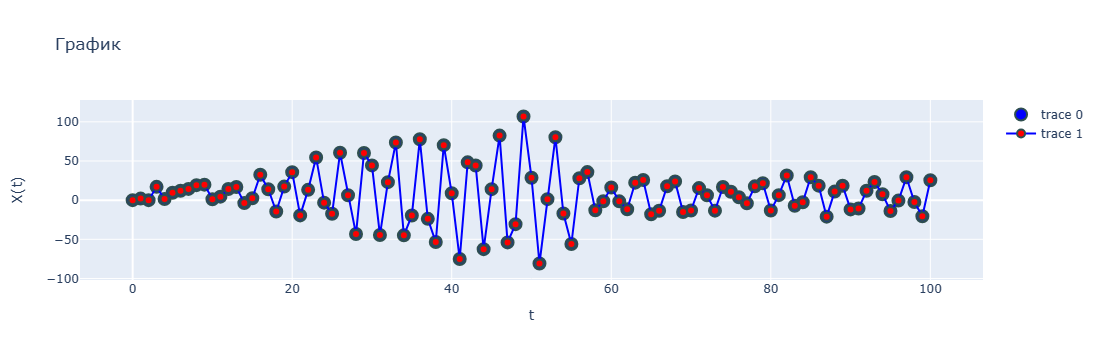

Start delta:  0.0010659538158074046
iterations:  1
result delta:  0.0010659538158074046


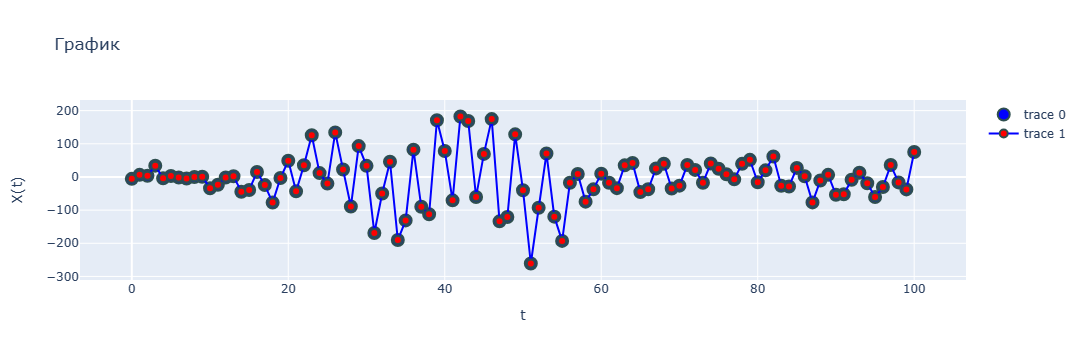

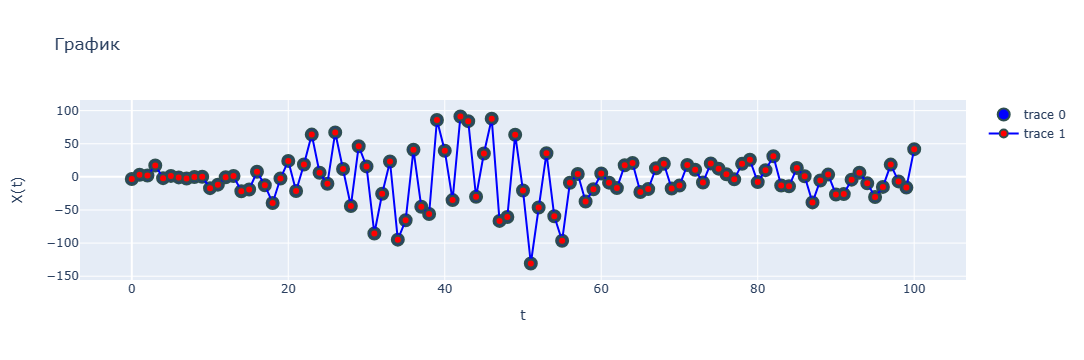

In [62]:
# Задаем гиперпараметры
x0 = 0.0
x1 = 2.0
mean = 0
sigma = 1
t = 50
n = 100
p= 2
eps = 0.1
def N_func(x, m=mean, std=sigma):
    return norm.cdf(x,loc=m, scale=std)
a_coef = np.array([ i * np.cos(np.cos(np.pi/6)) * (-1)**i for i in range(1,p+1)])
b_coef = np.array([i * (-1)**i for i in range(1,p+1)])
a_1 = [0.75, -0.5]
b_1 = [0.2, -0.7]
t, h_n, h = Visual_res2(a_1, b_1, eps, x0,x1, n, p, t)



In [41]:
def iFunc(x, h):
    

IndentationError: expected an indented block after function definition on line 1 (153539413.py, line 2)